Installing Torch geometric package

In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


In [1]:
import torch
import random
import matplotlib.pyplot as plt

/Users/vitthalsrinivasan/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Citeseer dataset from Planetoid.

The Citeseer dataset, often associated with the Planetoid benchmark, is a popular dataset used in graph-based semi-supervised learning, particularly for node classification tasks in graph neural networks (GNNs). 

The CiteSeer dataset consists of 3327 scientific publications classified into one of six classes.

- Agents
- Artificial Intelligence (AI)
- Database (DB)
- Information Retrieval (IR)
- Machine Learning (ML)
- Human-Computer Interaction (HCI)

The edges represent citation links between the documents, forming the structure of the citation network used in graph-based machine learning models.

Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 3703 unique words.

##### Normalize features
Row-normalizes the attributes given in attrs to sum-up to one (functional name: normalize_features).

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

citeseer_dataset = Planetoid(root = "Citeseer_dataset", name = "Citeseer", transform = NormalizeFeatures())

Processing...
Done!


In [3]:
len(citeseer_dataset)

1

In [4]:
citeseer_dataset.num_classes

6

In [5]:
citeseer_dataset.num_features

3703

In [8]:
citeseer_graph = citeseer_dataset[0]

citeseer_graph

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [9]:
citeseer_graph.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Training , validation and Test nodes are checked

In [10]:
print("Training samples: ", citeseer_graph.train_mask.sum().item())
print("Validation samples: ", citeseer_graph.val_mask.sum().item())
print("Test samples: ", citeseer_graph.test_mask.sum().item())

Training samples:  120
Validation samples:  500
Test samples:  1000


labels are checked

In [11]:
citeseer_graph.y

tensor([3, 1, 5,  ..., 3, 1, 5])

In [14]:
print(f'Number of nodes: {citeseer_graph.num_nodes}')
print(f'Number of edges: {citeseer_graph.num_edges}')
print(f'Average node degree: {citeseer_graph.num_edges / citeseer_graph.num_nodes:.2f}')
print(f'Has isolated nodes: {citeseer_graph.has_isolated_nodes()}')
print(f'Has self-loops: {citeseer_graph.has_self_loops()}')
print(f'Is undirected: {citeseer_graph.is_undirected()}')

Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Has isolated nodes: True
Has self-loops: False
Is undirected: True


Graph is plotted .
Agents: In computer science, an "agent" refers to a software entity that acts autonomously to perform tasks or make decisions on behalf of a user or another program. Agents are often used in areas such as artificial intelligence, robotics, and distributed systems.

AI: "AI" stands for Artificial Intelligence, which is the branch of computer science that focuses on creating systems that can perform tasks that typically require human intelligence. This includes tasks such as understanding natural language, recognizing patterns, learning from data, and making decisions.

DB: "DB" typically stands for Database. In the context of computer science, a database is an organized collection of structured data that is stored and managed electronically. Databases are commonly used in applications to store, retrieve, and manipulate data efficiently.

IR: "IR" stands for Information Retrieval. It is a field of computer science that deals with the retrieval of information from large collections of data, such as text documents or multimedia content. Information retrieval systems aim to provide users with relevant information in response to their queries.

ML: "ML" stands for Machine Learning, which is a subset of artificial intelligence that focuses on the development of algorithms and statistical models that enable computers to learn from and make predictions or decisions based on data. Machine learning techniques are used in various applications, including data analysis, pattern recognition, and predictive modeling.

HCI: "HCI" stands for Human-Computer Interaction, which is the study of how people interact with computers and technology. HCI focuses on designing and evaluating interfaces and systems that are intuitive, efficient, and user-friendly. It encompasses aspects such as usability, user experience, and interaction design.

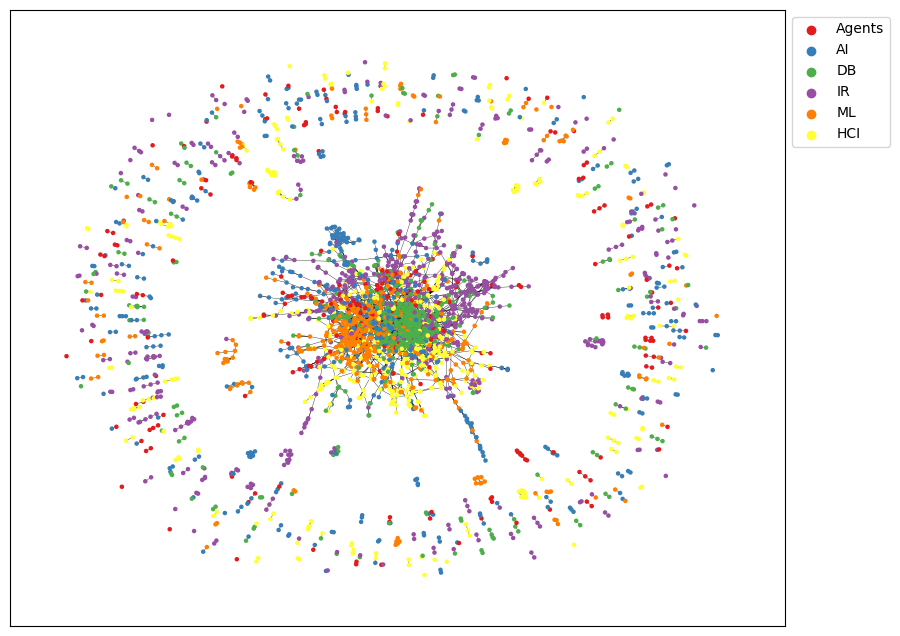

In [17]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Define label names and colors
label_dict = {
    0: "Agents",
    1: "AI",
    2: "DB",
    3: "IR",
    4: "ML",
    5: "HCI"
}

colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']

# Convert PyG graph to NetworkX graph
G = to_networkx(citeseer_graph, to_undirected = True)

# Prepare node colors and legends
node_color = [colorlist[int(label)] for label in citeseer_graph.y]
labellist = [label_dict[int(label)] for label in citeseer_graph.y]

# Plot the graph
pos = nx.spring_layout(G, seed = 42)

plt.figure(figsize = (10, 8))
nx.draw_networkx_nodes(G, pos, node_size = 5, node_color = node_color)
nx.draw_networkx_edges(G, pos, width = 0.25)

# Add legends
for label, color in zip(label_dict.values(), colorlist):
    plt.scatter([], [], c = color, label = label)

plt.legend(bbox_to_anchor = (1, 1), loc = "upper left")

plt.show()

https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=5IRdAELVKOl6

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Verifying that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes)

In [18]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features = input_channels, out_features = hidden_channels),
            nn.ReLU(),
            nn.Linear(in_features = hidden_channels, out_features = output_channels)
        )

    def forward(self, data):
         # only using node features (x)
        x = data.x 
        
        output = self.layers(x)
        
        return output

Model is instantiated with hidden channels and optimizer and criterion is defined

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

citeseer_graph = citeseer_dataset[0].to(device)

input_channels = citeseer_dataset.num_features

hidden_channels = 16

output_channels = citeseer_dataset.num_classes

In [27]:
model = MLP(
    input_channels = input_channels, 
    hidden_channels = hidden_channels, 
    output_channels = output_channels).to(device)

print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=3703, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=6, bias=True)
  )
)


In [28]:
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

criterion = nn.CrossEntropyLoss()

Number of parameters:  59366


Model is trained with epochs=200 and validation set accuracy is displayed after each epoch

In [29]:
num_epochs = 200

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()
    out = model(citeseer_graph)

    loss = criterion(out[citeseer_graph.train_mask], citeseer_graph.y[citeseer_graph.train_mask])
    loss.backward()

    optimizer.step()

    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)
    
    correct_train = (
        pred_train[citeseer_graph.train_mask] == citeseer_graph.y[citeseer_graph.train_mask]
    ).sum()
    
    acc_train = int(correct_train) / int(citeseer_graph.train_mask.sum())
    
    # Get predictions on validation data
    model.eval()

    pred_val = model(citeseer_graph).argmax(dim = 1)
    
    correct_val = (
        pred_val[citeseer_graph.val_mask] == citeseer_graph.y[citeseer_graph.val_mask]
    ).sum()
    
    acc_val = int(correct_val) / int(citeseer_graph.val_mask.sum())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 1.704,                Train Acc: 0.850 Val Acc: 0.330
Epoch: 020,                Train Loss: 1.512,                Train Acc: 0.925 Val Acc: 0.326
Epoch: 030,                Train Loss: 1.246,                Train Acc: 0.992 Val Acc: 0.400
Epoch: 040,                Train Loss: 0.956,                Train Acc: 1.000 Val Acc: 0.408
Epoch: 050,                Train Loss: 0.708,                Train Acc: 1.000 Val Acc: 0.444
Epoch: 060,                Train Loss: 0.527,                Train Acc: 1.000 Val Acc: 0.490
Epoch: 070,                Train Loss: 0.408,                Train Acc: 1.000 Val Acc: 0.518
Epoch: 080,                Train Loss: 0.333,                Train Acc: 1.000 Val Acc: 0.524
Epoch: 090,                Train Loss: 0.286,                Train Acc: 1.000 Val Acc: 0.540
Epoch: 100,                Train Loss: 0.254,                Train Acc: 1.000 Val Acc: 0.536
Epoch: 110,                Train Loss: 0.229,                Train Acc

Test accuracy is obtained

In [30]:
model.eval()

pred = model(citeseer_graph).argmax(dim = 1)

correct = (pred[citeseer_graph.test_mask] == citeseer_graph.y[citeseer_graph.test_mask]).sum()

test_acc = int(correct) / int(citeseer_graph.test_mask.sum())

test_acc

0.601

As one can see, our MLP performs rather bad with only about 59% test accuracy. But why does the MLP do not perform better? The main reason for that is that this model suffers from heavy overfitting due to only having access to a small amount of training nodes, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: Cited papers are very likely related to the category of a document. That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.

Let's visualize the node embeddings of our DNN model
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 6-dimensional node embeddings onto a 2D plane.

In [31]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components = 2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize = (8, 8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = "Set1")
    plt.show()

Node embedding shape: torch.Size([3327, 6])


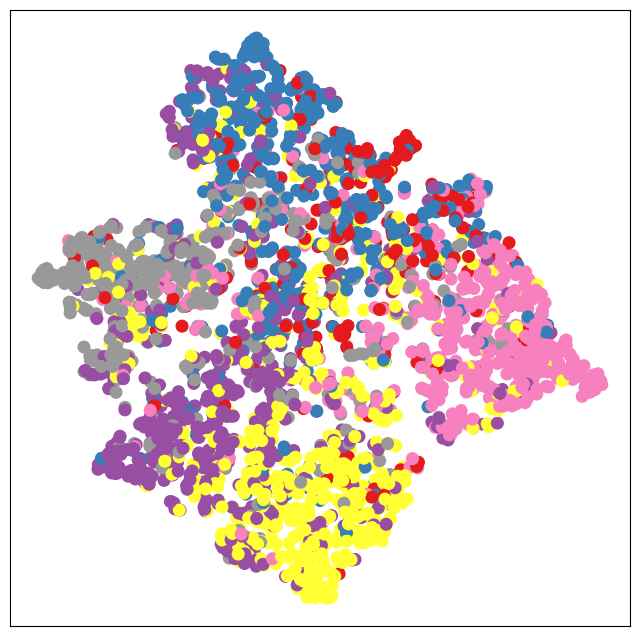

In [26]:
model.eval()

out = model(citeseer_graph)

print("Node embedding shape:", out.shape)

visualize(out, color = citeseer_graph.cpu().y)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

We replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.
Ref-doc-link-
https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html#learning-methods-on-graphs

In [32]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels = input_channels, out_channels = hidden_channels)
        self.conv2 = GCNConv(in_channels = hidden_channels, out_channels = output_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = F.dropout(x, training = self.training)

        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim = 1)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

citeseer_graph = citeseer_dataset[0].to(device)

input_channels = citeseer_dataset.num_features

hidden_channels = 32

output_channels = citeseer_dataset.num_classes

In [35]:
model = GCN(
    input_channels = input_channels, 
    hidden_channels = hidden_channels, 
    output_channels = output_channels).to(device)

print(model)

GCN(
  (conv1): GCNConv(3703, 32)
  (conv2): GCNConv(32, 6)
)


In [36]:
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 5e-4)

Number of parameters:  118726


In [37]:
for epoch in range(num_epochs):
    
    model.train()
    
    optimizer.zero_grad()
    out = model(citeseer_graph)
    
    loss = F.nll_loss(out[citeseer_graph.train_mask], citeseer_graph.y[citeseer_graph.train_mask])
    loss.backward()
    
    optimizer.step()
    
    # Get predictions on the training data
    pred_train = out.argmax(dim = 1)
    
    correct_train = (
        pred_train[citeseer_graph.train_mask] == citeseer_graph.y[citeseer_graph.train_mask]
    ).sum()
    
    acc_train = int(correct_train) / int(citeseer_graph.train_mask.sum())

    # Get predictions on validation data
    model.eval()

    pred_val = model(citeseer_graph).argmax(dim = 1)
    
    correct_val = (
        pred_val[citeseer_graph.val_mask] == citeseer_graph.y[citeseer_graph.val_mask]
    ).sum()
    
    acc_val = int(correct_val) / int(citeseer_graph.val_mask.sum())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1:03d}, \
               Train Loss: {loss:.3f}, \
               Train Acc: {acc_train:.3f} Val Acc: {acc_val:.3f}')

Epoch: 010,                Train Loss: 1.688,                Train Acc: 0.808 Val Acc: 0.640
Epoch: 020,                Train Loss: 1.529,                Train Acc: 0.850 Val Acc: 0.700
Epoch: 030,                Train Loss: 1.308,                Train Acc: 0.900 Val Acc: 0.688
Epoch: 040,                Train Loss: 1.105,                Train Acc: 0.858 Val Acc: 0.706
Epoch: 050,                Train Loss: 0.961,                Train Acc: 0.900 Val Acc: 0.706
Epoch: 060,                Train Loss: 0.813,                Train Acc: 0.900 Val Acc: 0.712
Epoch: 070,                Train Loss: 0.666,                Train Acc: 0.942 Val Acc: 0.698
Epoch: 080,                Train Loss: 0.614,                Train Acc: 0.908 Val Acc: 0.716
Epoch: 090,                Train Loss: 0.556,                Train Acc: 0.933 Val Acc: 0.724
Epoch: 100,                Train Loss: 0.482,                Train Acc: 0.958 Val Acc: 0.716
Epoch: 110,                Train Loss: 0.499,                Train Acc

 By simply swapping the linear layers with GNN layers, we can reach 71 % of test accuracy! This is in stark contrast to the 60% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

In [38]:
model.eval()

pred = model(citeseer_graph).argmax(dim = 1)

correct = (pred[citeseer_graph.test_mask] == citeseer_graph.y[citeseer_graph.test_mask]).sum()

test_acc = int(correct) / int(citeseer_graph.test_mask.sum())

test_acc

0.712

Classifications looks more accurate than our MLP model

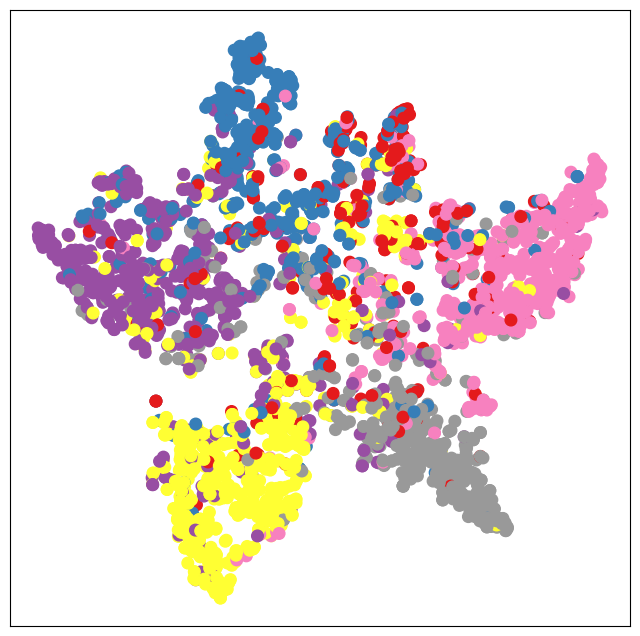

In [39]:
model.eval()

out = model(citeseer_graph)

visualize(out, color = citeseer_graph.cpu().y)